# Lab 3: Radial Basis Function (RBF) Networks

This notebook provides a basic, guided walkthrough of Radial Basis Function networks. You can run all the code and study how it works, then experiment with the parameters.

**Learning Objectives:**

1. Understand the architecture of RBF networks
2. See how RBF differs from Multi-Layer Perceptrons (MLPs)
3. Implement an RBF network from scratch
4. Apply RBF to the Iris classification problem
5. Compare RBF with MLP performance
6. Use sklearn's kernel methods as a library alternative

## 1. Introduction: What is an RBF Network?

An **RBF network** is a three-layer neural network used for:

* **Classification**
* **Function approximation**
* **Time series prediction**
* **System control**

### Key Differences from MLP

| **Aspect** | **MLP** | **RBF** |
|---|---|---|
| **Hidden layer activation** | Sigmoid (global) | Gaussian (local) |
| **Hidden layer weights** | Learned via backpropagation | None - stores prototypes |
| **Output layer activation** | Sigmoid | None (linear) |
| **Training** | Iterative gradient descent | Two-stage (prototypes, then weights) |
| **Response** | All neurons respond to all inputs | Only nearby neurons respond strongly |

### RBF Architecture

```
Input Layer          Hidden Layer (RBF)           Output Layer
                                                  
x₁ ----------------> ϕ(||x-p₁||) ------\
                                        \
x₂ ----------------> ϕ(||x-p₂||) --------> Σ -----> y₁
                                        /
...                  ...               /
                                      /
xₙ ----------------> ϕ(||x-pₙ||) ----/-----> Σ -----> y₂
```

Each RBF neuron stores a prototype (p_i) and computes similarity between the input and its prototype using a Gaussian function.

**Key Insight:** RBF neurons respond strongly only when the input is close to their prototype. This is fundamentally different from MLP neurons, which respond to weighted sums across the entire input space.

In [7]:
# Import required libraries

# Avoid KMeans memory leak issue on Windows with Intel MKL
import os
os.environ['OMP_NUM_THREADS'] = '1'
import warnings
warnings.filterwarnings('ignore', message='KMeans is known to have a memory leak*')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(42)
print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. The Gaussian (RBF) Activation Function

The core of an RBF network is the **Gaussian activation function**:

$$\varphi(x) = e^{-\beta||x-p||^2}$$

Where:

* $x$ is the input vector
* $p$ is the prototype (centre) stored by the neuron
* $||x - p||$ is the Euclidean distance between input and prototype
* $\beta$ controls the width of the Gaussian curve

### The β Parameter

* **Large β** → Narrow curve → Neuron responds only to inputs very close to prototype
* **Small β** → Wide curve → Neuron responds to inputs further from prototype

β can be computed from the standard deviation (σ) of the data:

$$\beta = \frac{1}{2\sigma^2}$$

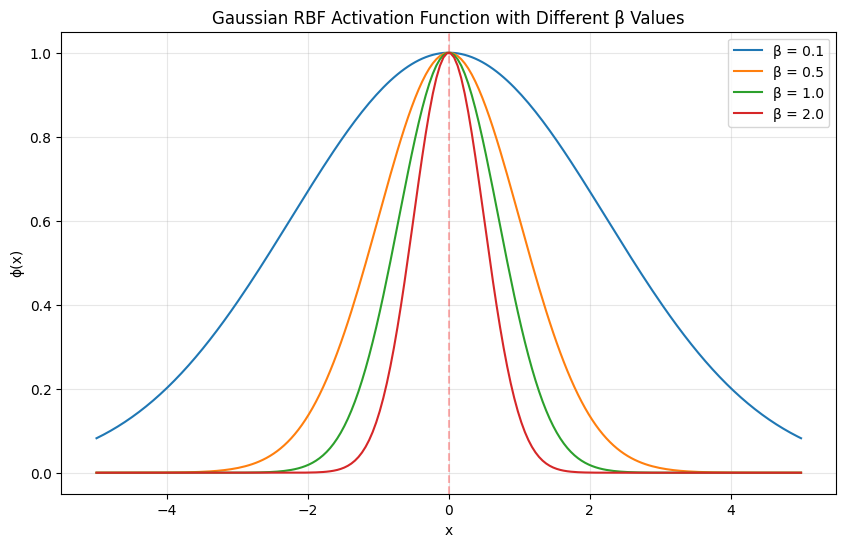


Key observation:
- When input equals prototype (distance = 0), activation = 1.0
- As input moves away from prototype, activation falls towards 0
- β controls how quickly the activation falls off


In [8]:
# Visualize the Gaussian function with different β values

def gaussian(x, centre, beta):
    """
    Compute Gaussian activation.
    
    Parameters:
        x: Input value(s)
        centre: The prototype/centre of the Gaussian
        beta: Width parameter = narrower curve
    
    Returns:
        Activation values
    """
    return np.exp(-beta * (x - centre)**2)

# Test with different β values
x = np.linspace(-5, 5, 200)
centre = 0.0

plt.figure(figsize=(10, 6))
for beta in [0.1, 0.5, 1.0, 2.0]:
    y = gaussian(x, centre, beta)
    plt.plot(x, y, label=f'β = {beta}')

plt.xlabel('x')
plt.ylabel('ϕ(x)')
plt.title('Gaussian RBF Activation Function with Different β Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=centre, color='red', linestyle='--', alpha=0.3, label='Centre')
plt.show()

print("\nKey observation:")
print("- When input equals prototype (distance = 0), activation = 1.0")
print("- As input moves away from prototype, activation falls towards 0")
print("- β controls how quickly the activation falls off")

## 3. RBF Network Implementation (From Scratch)

Now we'll implement a complete RBF network. The training process has two stages:

1. **Select prototypes** - Choose which training samples (or cluster centres) to use as RBF neuron centres
2. **Learn output weights** - Find the weights that map RBF activations to correct outputs

### Prototype Selection Methods

From the lecture slides, three options:

1. One RBF neuron for each training sample (expensive)
2. Randomly select k prototypes from the dataset
3. Use k-means clustering and take cluster centroids as prototypes (recommended)

We'll use **k-means clustering** as it provides well-distributed prototypes.

In [9]:
class RBFNetwork:
    """
    Radial Basis Function Network for classification.
    
    Architecture:
        - Input layer: passes input directly to hidden layer
        - Hidden layer: RBF neurons, each storing a prototype
        - Output layer: weighted sum (no activation function)
    
    Training:
        1. Select prototypes using k-means clustering
        2. Compute β from cluster spreads
        3. Learn output weights using pseudoinverse
    """
    
    def __init__(self, n_prototypes=10):
        """
        Initialise RBF network.
        
        Parameters:
            n_prototypes: Number of RBF neurons (prototypes) in hidden layer
        """
        self.n_prototypes = n_prototypes
        self.prototypes = None  # Will store prototype vectors
        self.betas = None       # Will store β for each prototype
        self.weights = None     # Will store output layer weights
    
    def _euclidean_distance(self, x, prototype):
        """
        Compute Euclidean distance between input and prototype.
        
        ||x - p|| = sqrt(Σ(xi - pi)²)
        
        ## TODO: use numpy's "sqrt" and "sum" (making axis=-1) functions
        ##       to compute and return the Euclidean distance
        """
        return np.sqrt(np.sum((x - prototype)**2, axis=-1))
    
    def _gaussian_activation(self, x, prototype, beta):
        """
        Compute Gaussian RBF activation.
        
        ϕ(x) = exp(-β * ||x - p||²)
        
        ## TODO: use _euclidean_distance() and NumPy's "exp" function to
        ##       compute and return the RBF activation value
        """
        distance = self._euclidean_distance(x, prototype)
        return np.exp(-beta * distance**2)
    
    def _compute_betas(self, kmeans, X):
        """
        Compute β for each prototype from cluster spreads.
        
        For each cluster:
            - Find all points belonging to this cluster
            - Compute average distance to cluster centre
            - β = 1 / (2 * sigma²), where sigma is the mean distance
        """
        self.betas = np.zeros(self.n_prototypes)
        
        for j in range(self.n_prototypes):
            # Find all points belonging to this cluster
            cluster_points = X[kmeans.labels_ == j]
            
            if len(cluster_points) > 1:
                # Compute average distance to cluster centre
                distances = self._euclidean_distance(cluster_points, self.prototypes[j])
                ## TODO: use NumPy's "mean" function to calculate "sigma" as the mean
                ##       of the Euclidean "distances"
                sigma = np.mean(distances)
                
                # Avoid division by zero
                if sigma > 0:
                    self.betas[j] = 1 / (2 * sigma ** 2)
                else:
                    self.betas[j] = 1.0  # Default if all points identical
            else:
                self.betas[j] = 1.0  # Default for single-point clusters
        
        print(f"  Stage 2: Computed β values (mean={self.betas.mean():.3f})")
    
    def _compute_hidden_activations(self, X):
        """
        Compute hidden layer activations for all training samples.
        
        For each sample and each prototype:
            activation = exp(-β * distance²)
        
        Returns:
            H: Hidden layer activation matrix, shape (n_samples, n_prototypes)
        """
        H = np.zeros((X.shape[0], self.n_prototypes))
        
        for j in range(self.n_prototypes):
            ## TODO: use _gaussian_activation() to compute the activations for
            ##       all samples X with respect to prototype j and beta j
            H[:, j] = self._gaussian_activation(X, self.prototypes[j], self.betas[j])
        
        return H
    
    def fit(self, X, y):
        """
        Train the RBF network.
        
        Stage 1: Find prototypes using k-means
        Stage 2: Compute β values
        Stage 3: Learn output weights
        """
        print("Training RBF Network...")
        
        # =====================================================================
        # STAGE 1: Select prototypes using k-means clustering
        # =====================================================================
        print(f"  Stage 1: Finding {self.n_prototypes} prototypes using k-means...")
        kmeans = KMeans(n_clusters=self.n_prototypes, random_state=42, n_init=10)
        kmeans.fit(X)
        self.prototypes = kmeans.cluster_centers_
        
        # =====================================================================
        # STAGE 2: Compute β values from cluster spreads
        # =====================================================================
        self._compute_betas(kmeans, X)
        
        # =====================================================================
        # STAGE 3: Learn output weights using least squares
        # =====================================================================
        # We need to find weights W such that: H @ W = Y
        # Where H is the hidden layer activation matrix
        # Solution: W = (H^T H)^-1 H^T Y (pseudoinverse)
        
        # Compute hidden layer activations for all training samples
        H = self._compute_hidden_activations(X)
        
        # Add bias column (column of 1s) to handle offset
        H_bias = np.column_stack([H, np.ones(H.shape[0])])
        
        # Convert y to one-hot if needed (for multi-class)
        ## TODO: use pinv(H) @ y
        n_classes = len(np.unique(y))
        y_onehot = np.zeros((len(y), n_classes))
        y_onehot[np.arange(len(y)), y] = 1
        
        # Compute weights using pseudoinverse (more stable than direct inverse)
        self.weights = np.linalg.pinv(H_bias) @ y_onehot
        
        print(f"  Stage 3: Learned output weights, shape={self.weights.shape}")
        print("Training complete!")
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities for input samples.
        
        Parameters:
            X: Input data, shape (n_samples, n_features)
        
        Returns:
            Class scores, shape (n_samples, n_classes)
        """
        # Compute hidden layer activations
        H = self._compute_hidden_activations(X)
        
        # Add bias column
        H_bias = np.column_stack([H, np.ones(H.shape[0])])
        
        # Compute output: weighted sum (no activation function)
        output = H_bias @ self.weights
        
        return output
    
    def predict(self, X):
        """
        Predict class labels for input samples.
        
        Parameters:
            X: Input data, shape (n_samples, n_features)
        
        Returns:
            Predicted class indices, shape (n_samples,)
        """
        scores = self.predict_proba(X)
        ## TODO: use NumPy's "argmax" function to identify and return the
        ##       indices of the highest values for each row of "scores".
        return np.argmax(scores, axis=1)

print("RBFNetwork class defined successfully!")
print("\nKey components:")
print("  - _euclidean_distance(): Computes ||x - p||")
print("  - _gaussian_activation(): Computes exp(-β * d²)")
print("  - fit(): Three-stage training (prototypes, betas, weights)")
print("  - predict(): Classification using trained network")

RBFNetwork class defined successfully!

Key components:
  - _euclidean_distance(): Computes ||x - p||
  - _gaussian_activation(): Computes exp(-β * d²)
  - fit(): Three-stage training (prototypes, betas, weights)
  - predict(): Classification using trained network
